## 1. <font color = red> Install and Import the Required Libraries

In [ ]:
# Install all the required libraries

!pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers

In [ ]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [ ]:
# Define the path of the PDF
single_pdf_path = '/content/drive/MyDrive/MLData/HelpAI/Principal-Sample-Life-Insurance-Policy.pdf'
# single_pdf_path = "/content/drive/My Drive/HelpMate AI Codes/Policy Documents/HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf"

In [ ]:
import pdfplumber
import json
from operator import itemgetter
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity

# Download necessary NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [ ]:
# Helper functions
def check_bboxes(word, table_bbox):
    return (word['x0'] >= table_bbox[0] and word['x1'] <= table_bbox[2] and
            word['top'] >= table_bbox[1] and word['bottom'] <= table_bbox[3])

def get_sentence_embedding(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

def semantic_based_chunking(text, tokenizer, model, threshold=0.8, max_chunk_size=512):
    sentences = sent_tokenize(text)
    embeddings = [get_sentence_embedding(sentence, tokenizer, model) for sentence in sentences]

    chunks = []
    current_chunk = sentences[0]
    current_embedding = embeddings[0]
    current_size = len(tokenizer.tokenize(current_chunk))

    for i in range(1, len(sentences)):
        similarity = cosine_similarity([current_embedding], [embeddings[i]])[0][0]
        sentence_size = len(tokenizer.tokenize(sentences[i]))

        if similarity >= threshold and (current_size + sentence_size) <= max_chunk_size:
            current_chunk += " " + sentences[i]
            current_embedding = (current_embedding * current_size + embeddings[i] * sentence_size) / (current_size + sentence_size)
            current_size += sentence_size
        else:
            chunks.append(current_chunk)
            current_chunk = sentences[i]
            current_embedding = embeddings[i]
            current_size = sentence_size

    if current_chunk:
        chunks.append(current_chunk)

    return chunks

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []

    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))

            page_text = " ".join(lines)
            page_chunks = semantic_based_chunking(page_text, tokenizer, model)
            full_text.append([page_no, page_chunks])
            p += 1

    return full_text




In [ ]:
# Example usage
pdf_path = "example.pdf"  # Replace with your PDF file path
extracted_text = extract_text_from_pdf(single_pdf_path)

In [ ]:
type(extracted_text)


list

In [ ]:
import pandas as pd

# Assuming 'extracted_text' is the output from your 'extract_text_from_pdf' function
# Flatten the list of lists, ensuring each item is a (page, text) tuple
flattened_text = [(page, text) for page, texts in extracted_text for text in texts]

insurance_pdfs_data = pd.DataFrame(flattened_text, columns=['Page No.', 'Page_Text'])  # Create a DataFrame

In [ ]:
insurance_pdfs_data

,Page No.,Page_Text
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,Page 2,This page left blank intentionally
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3,Page 3,EXCEPT AS SPECIFICALLY DESCRIBED IN THIS RIDER...
4,Page 3,"PRINCIPAL LIFE INSURANCE COMPANY DES MOINES, I..."
...,...,...
262,Page 62,Article 7 - Legal Action Legal action to recov...
263,Page 62,Article 8 - Time Limits Any time limits in thi...
264,Page 62,This policy has been updated effective January...
265,Page 63,This page left blank intentionally


In [ ]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data.Page_Text[2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [ ]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [ ]:
insurance_pdfs_data['Text_Length']

0       30
1        5
2      199
3       20
4       11
      ... 
262     57
263     18
264     22
265      5
266      8
Name: Text_Length, Length: 267, dtype: int64

In [ ]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,199
3,Page 3,EXCEPT AS SPECIFICALLY DESCRIBED IN THIS RIDER...,20
4,Page 3,"PRINCIPAL LIFE INSURANCE COMPANY DES MOINES, I...",11
6,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,82
...,...,...,...
259,Page 62,The Principal will pay for these examinations ...,15
260,Page 62,Article 6 - Autopsy If payment for loss of lif...,18
262,Page 62,Article 7 - Legal Action Legal action to recov...,57
263,Page 62,Article 8 - Time Limits Any time limits in thi...,18


In [ ]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': 'Principal-Sample-Life-Insurance-Policy.pdf', 'Page_No.': x['Page No.']}, axis=1)

<ipython-input-309-edc91a451d5e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': 'Principal-Sample-Life-Insurance-Policy.pdf', 'Page_No.': x['Page No.']}, axis=1)


In [ ]:
insurance_pdfs_data

,Page No.,Page_Text,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,199,{'Policy_Name': 'Principal-Sample-Life-Insuran...
3,Page 3,EXCEPT AS SPECIFICALLY DESCRIBED IN THIS RIDER...,20,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 3,"PRINCIPAL LIFE INSURANCE COMPANY DES MOINES, I...",11,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,82,{'Policy_Name': 'Principal-Sample-Life-Insuran...
...,...,...,...,...
259,Page 62,The Principal will pay for these examinations ...,15,{'Policy_Name': 'Principal-Sample-Life-Insuran...
260,Page 62,Article 6 - Autopsy If payment for loss of lif...,18,{'Policy_Name': 'Principal-Sample-Life-Insuran...
262,Page 62,Article 7 - Legal Action Legal action to recov...,57,{'Policy_Name': 'Principal-Sample-Life-Insuran...
263,Page 62,Article 8 - Time Limits Any time limits in thi...,18,{'Policy_Name': 'Principal-Sample-Life-Insuran...


## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [ ]:
# Set the API key
filepath = "/content/drive/MyDrive/MLData/GenAIShop/"

with open(filepath + "OPENAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [ ]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [ ]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/MyDrive/MLData/HelpAI/ChromaDB1'

In [ ]:
import chromadb

In [ ]:
# Call PersistentClient()

client = chromadb.PersistentClient()

In [ ]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [ ]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='Help_on_Insurance1', embedding_function=embedding_function)

In [ ]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [ ]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [ ]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.022469419986009598,
   0.01871146820485592,
   -0.02729734405875206,
   -0.031290166079998016,
   -0.0036731369327753782,
   0.027923669666051865,
   0.0008538575493730605,
   0.023656828328967094,
   -0.016571523621678352,
   0.004253792576491833,
   -0.005251998547464609,
   0.004058065824210644,
   -0.006273039150983095,
   0.023252326995134354,
   -0.011299951933324337,
   0.030977005138993263,
   0.002877181861549616,
   -0.024726800620555878,
   0.03055945597589016,
   0.007920404896140099,
   0.006413309834897518,
   0.01886804960668087,
   0.00953188817948103,
   0.012689611874520779,
   -0.012356876395642757,
   -0.009440548717975616,
   0.017889415845274925,
   -0.021686512976884842,
   0.023526344448328018,
   0.0030223457142710686,
   0.013283316045999527,
   -0.0145490150898695,
   -0.03361279144883156,
   -0.041180890053510666,
   -0.00845539104193449,
   0.013531235978007317,
   -0.0026716687716543674,
   -0.003868863452225923

In [ ]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [ ]:
cache_collection.peek()

{'ids': ['How much cover it has in case of disability?',
  'What are covered loss and benefit included in policy?',
  'What are payment responsibilities , due date & grace periods?',
  'What are the Repatriation Benefit?',
  'What are the condition for Member Life Insurance termination?',
  'how it determine amount of premium paid?',
  'how much grace periods specified in policy?',
  'what are the premium rate for Member Accidental Death and Dismemberment Insurance?'],
 'embeddings': [[0.01813538372516632,
   0.007501333951950073,
   0.02377955988049507,
   -0.02313186600804329,
   -0.009814520366489887,
   0.01633770763874054,
   -0.04454536736011505,
   -0.016932526603341103,
   -0.02630423754453659,
   0.019999152049422264,
   0.005862276069819927,
   0.04311779886484146,
   -0.005736703053116798,
   0.015134849585592747,
   0.007745870854705572,
   0.017619874328374863,
   0.029582353308796883,
   0.002805565018206835,
   0.005148492753505707,
   -0.02323761209845543,
   -0.0004729

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [ ]:
# Read the user query

query = 'how will the amount of premium to be paid on each due date be determined?'



In [ ]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [ ]:
#cache_results

In [ ]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
results

{'ids': [['66', '69', '67', '61', '59', '71', '138', '72', '127', '63']],
 'distances': [[0.21730419993400574,
   0.2984081208705902,
   0.2984335124492645,
   0.3105679750442505,
   0.3111721873283386,
   0.3279930055141449,
   0.3324715495109558,
   0.3407842218875885,
   0.36096644401550293,
   0.3630516827106476]],
 'metadatas': [[{'Page_No.': 'Page 21',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy.pdf'},
   {'Page_No.': 'Page 21',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy.pdf'},
   {'Page_No.': 'Page 21',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy.pdf'},
   {'Page_No.': 'Page 20',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy.pdf'},
   {'Page_No.': 'Page 20',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy.pdf'},
   {'Page_No.': 'Page 22',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy.pdf'},
   {'Page_No.': 'Page 44',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy.pdf'},
   {'Page_No.':

In [ ]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
           continue
        for i in range(10):
          if i == 0:
            continue
          Keys.append(str(key)+str(i-1))
          Values.append(str(val[0][i-1]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })

Found in cache!


In [ ]:
results_df

,IDs,Documents,Distances,Metadatas
0,66,Article 4 - Premium Amount The amount of premi...,0.26158207654953003,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi..."
1,67,The result will then be multiplied by the prem...,0.2862014174461365,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi..."
2,69,The result will then be multiplied by the prem...,0.28621184825897217,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi..."
3,71,The number of Members insured for Dependent Li...,0.31876417994499207,"{'Page_No.': 'Page 22', 'Policy_Name': 'Princi..."
4,138,(4) Premium will be based on the Dependent's a...,0.35144102573394775,"{'Page_No.': 'Page 44', 'Policy_Name': 'Princi..."
5,61,The first premium is due on the Date of Issue ...,0.35374030470848083,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi..."
6,72,"To ensure accurate premium calculations, the P...",0.3562306761741638,"{'Page_No.': 'Page 22', 'Policy_Name': 'Princi..."
7,127,"(3) The policy will be on one of the forms, ot...",0.36664149165153503,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi..."
8,59,Section B - Premiums Article 1 - Payment Respo...,0.3671336770057678,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi..."


## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

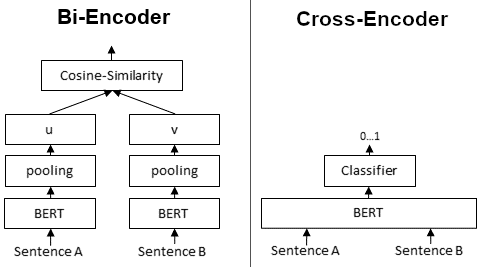

<br>

In [ ]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [ ]:
# Initialise the cross encoder model

!pip install huggingface_hub

import huggingface_hub
huggingface_hub.login(token='YOUR HUGGINGFACE TOKEN')  # Replace '<your_token>' with your actual token

# Now try loading the model again
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [ ]:
scores

array([  3.8467617, -11.252879 ], dtype=float32)

In [ ]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [ ]:
cross_rerank_scores

array([ 9.439875  , -0.57172966, -0.57172966, -5.5958757 , -2.927692  ,
        2.7573028 , -6.152508  , -2.8653321 , -1.000771  ], dtype=float32)

In [ ]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [ ]:
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,66,Article 4 - Premium Amount The amount of premi...,0.26158207654953003,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",9.439875
1,67,The result will then be multiplied by the prem...,0.2862014174461365,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",-0.571730
2,69,The result will then be multiplied by the prem...,0.28621184825897217,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",-0.571730
3,71,The number of Members insured for Dependent Li...,0.31876417994499207,"{'Page_No.': 'Page 22', 'Policy_Name': 'Princi...",-5.595876
4,138,(4) Premium will be based on the Dependent's a...,0.35144102573394775,"{'Page_No.': 'Page 44', 'Policy_Name': 'Princi...",-2.927692
5,61,The first premium is due on the Date of Issue ...,0.35374030470848083,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi...",2.757303
6,72,"To ensure accurate premium calculations, the P...",0.3562306761741638,"{'Page_No.': 'Page 22', 'Policy_Name': 'Princi...",-6.152508
7,127,"(3) The policy will be on one of the forms, ot...",0.36664149165153503,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",-2.865332
8,59,Section B - Premiums Article 1 - Payment Respo...,0.3671336770057678,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi...",-1.000771


In [ ]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,66,Article 4 - Premium Amount The amount of premi...,0.26158207654953003,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",9.439875
1,67,The result will then be multiplied by the prem...,0.2862014174461365,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",-0.571730
2,69,The result will then be multiplied by the prem...,0.28621184825897217,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",-0.571730


In [ ]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,66,Article 4 - Premium Amount The amount of premi...,0.26158207654953003,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",9.439875
5,61,The first premium is due on the Date of Issue ...,0.35374030470848083,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi...",2.757303
1,67,The result will then be multiplied by the prem...,0.2862014174461365,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",-0.571730


In [ ]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [ ]:
top_3_RAG

,Documents,Metadatas
0,Article 4 - Premium Amount The amount of premi...,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi..."
5,The first premium is due on the Date of Issue ...,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi..."
1,The result will then be multiplied by the prem...,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi..."


## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [ ]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [ ]:
# Generate the response

response = generate_response(query, top_3_RAG)

In [ ]:
# Print the response

print("\n".join(response))

To determine the amount of premium to be paid on each due date, the policy document explains that the first premium is due on the Date of Issue. The premium amount is calculated based on a specified formula which involves the result of certain calculations being multiplied by the premium rate.

Here is a clear breakdown of how the premium amount is determined:
1. The first premium is due on the Date of Issue.
2. The premium amount calculation involves certain calculations, and the result of these calculations is then multiplied by the premium rate.

Therefore, the premium amount to be paid on each due date is determined through the specified formula involving initial calculations and multiplication by the premium rate.

Citation:
- Policy Name: Principal Insurance Policy
- Relevant Page: Page 20
